## Gathering Docs

### Run the following command in the jupyter terminal to clone MDN glossary repo: git clone https://github.com/mdn/content.git

## Set-Up

In [1]:
%pip install -U python-terrier jpype1


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install python-frontmatter


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install markdown


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install nltk


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install python-terrier datasets nltk flask


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os 
from pathlib import Path
import pandas as pd
import numpy as np
import frontmatter
import re
import markdown
from bs4 import BeautifulSoup
import pyterrier as pt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import html
from flask import Flask, request, render_template
import requests
import urllib3
import time

In [7]:
mdn_glossary_path = Path(f"{os.getcwd()}/content/files/en-us/glossary")

# veriyfing that all the files are there
for item in mdn_glossary_path.iterdir():
    print(item)

/home/jovyan/TechGlossary/content/files/en-us/glossary/head
/home/jovyan/TechGlossary/content/files/en-us/glossary/arpanet
/home/jovyan/TechGlossary/content/files/en-us/glossary/grid_areas
/home/jovyan/TechGlossary/content/files/en-us/glossary/hyperlink
/home/jovyan/TechGlossary/content/files/en-us/glossary/promise
/home/jovyan/TechGlossary/content/files/en-us/glossary/regular_expression
/home/jovyan/TechGlossary/content/files/en-us/glossary/loop
/home/jovyan/TechGlossary/content/files/en-us/glossary/first_contentful_paint
/home/jovyan/TechGlossary/content/files/en-us/glossary/method
/home/jovyan/TechGlossary/content/files/en-us/glossary/document_directive
/home/jovyan/TechGlossary/content/files/en-us/glossary/cross-site_scripting
/home/jovyan/TechGlossary/content/files/en-us/glossary/mutable
/home/jovyan/TechGlossary/content/files/en-us/glossary/accessibility_tree
/home/jovyan/TechGlossary/content/files/en-us/glossary/stacking_context
/home/jovyan/TechGlossary/content/files/en-us/glos

## Step 1. Parse MDN glossary repo

In [8]:
#To investigate content of a single document
term = "png"
with open(f"{os.getcwd()}/content/files/en-us/glossary/{term}/index.md", "r") as f:
    content = f.read()
    post = frontmatter.loads(content)
    
    html_content = markdown.markdown(post.content)
    
    # Extract plain text from HTML
    plain_text = BeautifulSoup(html_content, "html.parser").get_text()
    
    df = pd.DataFrame([plain_text], columns=["content"])
    
    display(df)

,content
0,PNG (Portable Network Graphics) is a graphics ...


In [9]:
# Creating df to build pyterrier index with html for later display 
def load_mdn_glossary_for_pyterrier(glossary_root: str) -> pd.DataFrame:
    """
    Iterate through all subfolders in the glossary folder,
    read each Markdown file, clean text for indexing, replace
    all double-bracketed shortcodes with just the first term,
    remove Markdown formatting, and return a DataFrame with columns:
    - docno: unique document identifier
    - text: cleaned plain text for search/indexing
    """
    rows = []

    # Regex to match any {{Shortcode("term", ...)}}
    double_bracket_regex = re.compile(
        r'\{\{\s*[\w]+\(\s*["\'](.*?)["\'].*?\)\s*\}\}', re.IGNORECASE
    )

    for term_folder in os.listdir(glossary_root):
        folder_path = os.path.join(glossary_root, term_folder)
        if os.path.isdir(folder_path):
            md_file = os.path.join(folder_path, "index.md")
            if os.path.exists(md_file):
                try:
                    # Load Markdown with frontmatter
                    post = frontmatter.load(md_file)

                    # Replace any {{Shortcode(...)}} with just the first argument
                    content_no_placeholders = double_bracket_regex.sub(r'\1', post.content)

                    # Convert Markdown → HTML
                    html_content = markdown.markdown(content_no_placeholders)

                    # Convert HTML → plain text (removes **bold**, links, code formatting)
                    plain_text = BeautifulSoup(html_content, "html.parser").get_text()

                    # Clean up extra whitespace
                    clean_text = re.sub(r"\s+", " ", plain_text).strip()

                    # Assign docno (using folder name)
                    docno = term_folder

                    # Add row to DataFrame
                    rows.append({
                        "docno": docno,
                        "text": clean_text
                    })

                except Exception as e:
                    print(f"Error processing {md_file}: {e}")

    df = pd.DataFrame(rows, columns=["docno", "text"])
    return df

glossary_root = f"{os.getcwd()}/content/files/en-us/glossary"
mdn_df = load_mdn_glossary_for_pyterrier(glossary_root)

pd.set_option("display.max_colwidth", None)  # do not truncate text
display(mdn_df)

,docno,text
0,head,"The Head is the part of an HTML document that contains metadata about that document, such as author, description, and links to CSS or JavaScript files that should be applied to the HTML. See also head element reference on MDN What's in the head? Web page metadata on the MDN Learning Area"
1,arpanet,"The ARPANET (Advanced Research Projects Agency NETwork) was an early computer network, constructed in 1969 as a robust medium to transmit sensitive military data and to connect leading research groups throughout the United States. ARPANET first ran NCP (Network Control Protocol) and subsequently the first version of the Internet protocol or TCP/IPv4 suite, making ARPANET a prominent part of the nascent Internet. ARPANET was closed in early 1990. See also ARPANET on Wikipedia Related glossary terms: arpa TCP"
2,grid_areas,"A grid area is one or more grid cell that make up a rectangular area on the grid. Grid areas are created when you place an item using line-based placement or when defining areas using named grid areas. Grid areas must be rectangular in nature; it is not possible to create, for example, a T- or L-shaped grid area. Example In the example below I have a grid container with two grid items. I have named these with the grid-area property and then laid them out on the grid using grid-template-areas. This creates two grid areas, one covering four grid cells, the other two. ```css hidden * { box-sizing: border-box; } .wrapper { border: 2px solid #f76707; border-radius: 5px; background-color: #fff4e6; } .wrapper > div { border: 2px solid #ffa94d; border-radius: 5px; background-color: #ffd8a8; padding: 1em; color: #d9480f; } ``` css .wrapper { display: grid; grid-template-columns: repeat(3, 1fr); grid-template-rows: 100px 100px; grid-template-areas: ""a a b"" ""a a b""; } .item1 { grid-area: a; } .item2 { grid-area: b; } ```html Item Item ``` Example See also Property reference grid-template-columns grid-template-rows grid-auto-rows grid-auto-columns grid-template-areas grid-area Further reading CSS grid layout Guide: Basic concepts of grid layout Grid template areas Definition of grid areas in the CSS grid layout specification"
3,hyperlink,"Hyperlinks connect webpages or data items to one another. In HTML, a elements define hyperlinks from a spot on a webpage (like a text string or image) to another spot on some other webpage (or even on the same page). See also Hyperlink on Wikipedia Creating links <a> on MDN <link> on MDN"
4,promise,"A Promise is an object that's returned by a function that has not yet completed its work. The promise literally represents a promise made by the function that it will eventually return a result through the promise object. When the called function finishes its work asynchronous, a function on the promise object called a resolution (or fulfillment, or completion) handler is called to let the original caller know that the task is complete. See also Futures and promises Promise in the JavaScript Reference. Using promises"
...,...,...
597,smoke_test,"A smoke test consists of functional or unit tests of critical software functionality. Smoke testing comes before further, in-depth testing. Smoke testing answers questions like ""Does the program start up correctly?"" ""Do the main control buttons function?"" ""Can you save a simple blank new test user account?"" If this basic functionality fails, there is no point investing time in more detailed QA work at this stage. See also Smoke testing (software) on Wikipedia"
598,page_prediction,"Page Prediction is a browser feature or script which, when enabled, tells the browser to download resources the user is likely to visit before the user requests the content. Page prediction improves performance by enabling almost instant loading of predicted content. However, page prediction may also download content a user does not seek. Some web applications include a prediction feature completing search text and address bar URLs based on browsing

## Parse glossaryTech

In [10]:
# Run this once to download all the glossary files onto your local
# downloading all the glossary terms from https://glossarytech.com
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
base_url = "https://glossarytech.com"
categories = {'game_development': 1, 'software-infrastructure-devops': 8, 'quality_assurance-qa': 6, 
              'web_design': 3, 'front_end-technologies': 7, 'javascript': 2, 'java': 6, 'golang': 1, 'ios': 3, 
              'android': 2, 'cross_platform-hybrid': 2, 'databases': 5, 'product_management': 1, 'project_management': 2, 
             'leadership': 2, 'development_methodologies': 1, 'software_architecture': 3, 'fundamental_programming_concepts': 1, 
             'programming_paradigms': 1, 'data-science': 6, 'artificial-intelligence-ai': 3, 'tools': 9, 'roles_in_software_development': 2, 
             'embedded': 1, 'cloud_computing': 3, 'cyber_security': 4, 'blockchain': 3, 'general_terms': 12}

directory = "glossary_tech"
os.makedirs(directory, exist_ok=True)
total_pages = 0
if os.listdir(directory):
    print(f"Directory '{directory}' already has content. Skipping download.")
else:
    for category, num_pages in categories.items():
        for i in range(1, num_pages + 1): 
            url = f"{base_url}/terms/{category}" if i == 1 else f"{base_url}/terms/{category}/page{i}"
            r = requests.get(url, verify=False)
            if r.status_code != 200:
                continue
            filepath = os.path.join(directory, f"{category}_page{i}.html")
            with open(filepath, "w", encoding="utf-8") as f:
                f.write(r.text)
            print(f"Saving file: {category}_page{i}.html")
            total_pages += 1
            time.sleep(0.5)
print(f"Downloaded {total_pages} pages from glossary tech")

Directory 'glossary_tech' already has content. Skipping download.
Downloaded 0 pages from glossary tech


In [11]:
glossary_items = []

def clean_text_from_cell(cell):
    text = " ".join(cell.stripped_strings)
    text = html.unescape(text) # unescape HTML entities
    text = text.replace('\xa0', ' ') # replace non-breaking space with normal space
    text = re.sub(r'\s+([?,.!;:])', r'\1', text) # remove space before punctuation: "XML , " -> "XML,"
    text = re.sub(r'([?,.!;:])\s*', r'\1 ', text) # one space after punctuation
    text = re.sub(r'\s+\)', r')', text) # spaces around opening parenthesis
    text = re.sub(r'\(\s+', r'(', text) # spaces around closing parenthesis
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_html_glossary(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        html_content = f.read()
    
    soup = BeautifulSoup(html_content, "html.parser")
    tables = soup.find_all("table")
    for table in tables: 
        rows = table.find_all("tr", attrs={"data-term": True})
        for row in rows: 
            cells = row.find_all("td")
            if len(cells) >= 2:  
                term = clean_text_from_cell(cells[0])
                description = clean_text_from_cell(cells[1])
            glossary_items.append({'docno': term, 'text': description})


directory = "glossary_tech"
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)  
    if os.path.isfile(filepath): # check not subdirectory 
        load_html_glossary(filepath)
        
html_df = pd.DataFrame(glossary_items)
# print(html_df.head())
display(html_df)
print(f"Number of terms parsed: {len(html_df)}")

,docno,text
0,Spine JS,"A JavaScript MVC framework for building web apps. Aims to simplify MVC and integrates well with CoffeeScript. It is simple, lightweight, has minimal dependencies and approachable source code; great for teams."
1,SSGs,"SSGs typically stand for Static Site Generators. These are tools or frameworks used in web development to generate static websites from various data sources, templates, and content. They offer the advantage of faster load times and security compared to dynamic websites while making it easier to manage content and structure."
2,SSR,Stands for server-side rendering. SSR is a popular technique for rendering a normally client-side only single page app (SPA) on the server and then sending a fully rendered page to the client.
3,Storybook,"An open source tool for developing UI components in isolation for React, Vue, and Angular."
4,Styled Components,"One of the new ways to use CSS in modern JavaScript. It is the meant to be a successor of CSS Modules, a way to write CSS that's scoped to a single component, and not leak to any other element in the page."
...,...,...
2152,Penetration testing,"A product or service for an authorized attempt to bypass the means of protecting the information system. The result of the test is a report that can / must contain a list of detected vulnerabilities, used attack vectors, achieved results, recommendations for correction."
2153,Performance testing,"Testing, which is conducted to determine how quickly the computer system or part of it under a certain load. It can also serve to verify and confirm other attributes of system quality, such as scalability, reliability and resource consumption."
2154,PhantomJS,"A headless (without GUI) browser used for automating web page interaction, providing JavaScript API it enables automated navigation, screenshots, etc, it used to run browser-based unit tests in a headless system."
2155,PHPUnit,A unit testing framework for the PHP that aims to find mistakes in newly committed code quickly asserting that no code regression is in other parts of the code base.


Number of terms parsed: 2157


In [12]:
# Combining the two tables together (html_df & mdn_df)
print(html_df.dtypes)
print(mdn_df.dtypes)

df = pd.concat([html_df, mdn_df], ignore_index=True)
display(df)
print(f"Number of combined terms: {len(df)}")

docno    object
text     object
dtype: object
docno    object
text     object
dtype: object


,docno,text
0,Spine JS,"A JavaScript MVC framework for building web apps. Aims to simplify MVC and integrates well with CoffeeScript. It is simple, lightweight, has minimal dependencies and approachable source code; great for teams."
1,SSGs,"SSGs typically stand for Static Site Generators. These are tools or frameworks used in web development to generate static websites from various data sources, templates, and content. They offer the advantage of faster load times and security compared to dynamic websites while making it easier to manage content and structure."
2,SSR,Stands for server-side rendering. SSR is a popular technique for rendering a normally client-side only single page app (SPA) on the server and then sending a fully rendered page to the client.
3,Storybook,"An open source tool for developing UI components in isolation for React, Vue, and Angular."
4,Styled Components,"One of the new ways to use CSS in modern JavaScript. It is the meant to be a successor of CSS Modules, a way to write CSS that's scoped to a single component, and not leak to any other element in the page."
...,...,...
2754,smoke_test,"A smoke test consists of functional or unit tests of critical software functionality. Smoke testing comes before further, in-depth testing. Smoke testing answers questions like ""Does the program start up correctly?"" ""Do the main control buttons function?"" ""Can you save a simple blank new test user account?"" If this basic functionality fails, there is no point investing time in more detailed QA work at this stage. See also Smoke testing (software) on Wikipedia"
2755,page_prediction,"Page Prediction is a browser feature or script which, when enabled, tells the browser to download resources the user is likely to visit before the user requests the content. Page prediction improves performance by enabling almost instant loading of predicted content. However, page prediction may also download content a user does not seek. Some web applications include a prediction feature completing search text and address bar URLs based on browsing history and related searches. For example, as the user types in the address bar, the browser might send the current text in the address bar to the search engine before the user submits the request. Although browser page prediction and prediction services enable faster page loads, they consume additional bandwidth. Also, pre-loaded websites and embedded content can set and read their cookies as if they were visited even if they weren't. See also Related glossary terms: prerender prefetch"
2756,blink_element,"The <blink> element (blink tag) is an obsolete HTML feature no longer supported by web browsers and no longer documented on MDN. It was used to make text content blink on and off (flash) continually. The <blink> element was used like this: html example-bad <blink>In ancient browsers, I may have blinked</blink> Brief history In the early days of the web (the early- to mid-90s), there were not many features available for styling web pages. The CSS specification (version 1) was first released in 1996 and not adopted consistently by browsers until much later. Before CSS, browsers experimented with several features to make particular text sections stand out and grab the user's attention. The <blink> element was one of these, introduced in early versions of Netscape Navigator; Internet Explorer's marquee element was another. The <blink> element was apparently created after a conversation in a bar in Mountain View between Netscape engineer Lou Montulli and colleagues. When he went into the office the next morning, he found that one of his fellow engineers had stayed up all night and implemented it (read the story here). While initially popular, <blink> became much maligned because of overuse; many people found it annoying. More importantly, it degrades readability and can be particularly problematic for users with visual impairments or cognitive disorders such as epilepsy or ADHD. It can be dis

Number of combined terms: 2759


## Pyterrier Set-Up

In [13]:
# Point PyTerrier to your freshly installed JDK
os.environ["JAVA_HOME"] = os.path.expanduser("~/jdk/jdk-17.0.8+7")
os.environ["JVM_PATH"]  = os.path.join(os.environ["JAVA_HOME"], "lib/server/libjvm.so")
os.environ["PATH"]      = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

# Confirm libjvm.so exists
!ls $JVM_PATH

# Initialize PyTerrier
if not pt.java.started():
     pt.java.init()

print(" PyTerrier initialized successfully with local JDK.")

/home/jovyan/jdk/jdk-17.0.8+7/lib/server/libjvm.so
 PyTerrier initialized successfully with local JDK.


Java started and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


## Step 2. Pre-process 
Preprocessing choices determine what the model can “see.” We will adopt a minimal but effective pipeline:

- Lowercasing to normalize case.
- Tokenization on alphabetic words of length ≥3.
- Stopword removal to reduce high-frequency function words.
- Stemming to conflate morphological variants (e.g., “running” → “run”).

## Tokenization

In [14]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.isalpha() and w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

## Building the Pyterrier Index

In [15]:
# Pre-processing to add the term back into cleaned description to boost results for exact query matching 
df['clean_descr'] = df['text'].apply(clean_text)
df['clean_term'] = df['docno'].astype(str).apply(clean_text) 
df['clean_text'] = df['clean_term'] + " . " + df['clean_descr'] + " . " + df['clean_term']

display(df)


,docno,text,clean_descr,clean_term,clean_text
0,Spine JS,"A JavaScript MVC framework for building web apps. Aims to simplify MVC and integrates well with CoffeeScript. It is simple, lightweight, has minimal dependencies and approachable source code; great for teams.",a javascript mvc framework build web app aim simplifi mvc integr well coffeescript it simpl lightweight minim depend approach sourc code great team,spine js,spine js . a javascript mvc framework build web app aim simplifi mvc integr well coffeescript it simpl lightweight minim depend approach sourc code great team . spine js
1,SSGs,"SSGs typically stand for Static Site Generators. These are tools or frameworks used in web development to generate static websites from various data sources, templates, and content. They offer the advantage of faster load times and security compared to dynamic websites while making it easier to manage content and structure.",ssg typic stand static site gener these tool framework use web develop gener static websit variou data sourc templat content they offer advantag faster load time secur compar dynam websit make easier manag content structur,ssg,ssg . ssg typic stand static site gener these tool framework use web develop gener static websit variou data sourc templat content they offer advantag faster load time secur compar dynam websit make easier manag content structur . ssg
2,SSR,Stands for server-side rendering. SSR is a popular technique for rendering a normally client-side only single page app (SPA) on the server and then sending a fully rendered page to the client.,stand render ssr popular techniqu render normal singl page app spa server send fulli render page client,ssr,ssr . stand render ssr popular techniqu render normal singl page app spa server send fulli render page client . ssr
3,Storybook,"An open source tool for developing UI components in isolation for React, Vue, and Angular.",an open sourc tool develop ui compon isol react vue angular,storybook,storybook . an open sourc tool develop ui compon isol react vue angular . storybook
4,Styled Components,"One of the new ways to use CSS in modern JavaScript. It is the meant to be a successor of CSS Modules, a way to write CSS that's scoped to a single component, and not leak to any other element in the page.",one new way use css modern javascript it meant successor css modul way write css scope singl compon leak element page,style compon,style compon . one new way use css modern javascript it meant successor css modul way write css scope singl compon leak element page . style compon
...,...,...,...,...,...
2754,smoke_test,"A smoke test consists of functional or unit tests of critical software functionality. Smoke testing comes before further, in-depth testing. Smoke testing answers questions like ""Does the program start up correctly?"" ""Do the main control buttons function?"" ""Can you save a simple blank new test user account?"" If this basic functionality fails, there is no point investing time in more detailed QA work at this stage. See also Smoke testing (software) on Wikipedia",a smoke test consist function unit test critic softwar function smoke test come test smoke test answer question like doe program start correctli do main control button function can save simpl blank new test user account if basic function fail point invest time detail qa work stage see also smoke test softwar wikipedia,,. a smoke test consist function unit test critic softwar function smoke test come test smoke test answer question like doe program start correctli do main control button function can save simpl blank new test user account if basic function fail point invest time detail qa work stage see also smoke test softwar wikipedia .
2755,page_prediction,"Page Prediction is a browser feature or script which, when enabled, tells the browser to download resources the user is likely to visit before the user requests the content. Page prediction improves performance by enabling almost instant lo

In [16]:
display(df)
# Prepare documents for PyTerrier
docs_for_index = [{"docno": row["docno"], "text": row["clean_text"]} for _, row in df.iterrows()]
# print(docs_for_index)

# Build index
indexer = pt.IterDictIndexer("./glossary_index", overwrite=True)  # folder to store index
index_ref = indexer.index(docs_for_index)

# uncomment 2 previous lines if haven't build index yet
# index_ref = pt.IndexFactory.of("./glossary_index/data.properties")
print(f"Indexing complete! Your glossary is ready for retrieval.")

,docno,text,clean_descr,clean_term,clean_text
0,Spine JS,"A JavaScript MVC framework for building web apps. Aims to simplify MVC and integrates well with CoffeeScript. It is simple, lightweight, has minimal dependencies and approachable source code; great for teams.",a javascript mvc framework build web app aim simplifi mvc integr well coffeescript it simpl lightweight minim depend approach sourc code great team,spine js,spine js . a javascript mvc framework build web app aim simplifi mvc integr well coffeescript it simpl lightweight minim depend approach sourc code great team . spine js
1,SSGs,"SSGs typically stand for Static Site Generators. These are tools or frameworks used in web development to generate static websites from various data sources, templates, and content. They offer the advantage of faster load times and security compared to dynamic websites while making it easier to manage content and structure.",ssg typic stand static site gener these tool framework use web develop gener static websit variou data sourc templat content they offer advantag faster load time secur compar dynam websit make easier manag content structur,ssg,ssg . ssg typic stand static site gener these tool framework use web develop gener static websit variou data sourc templat content they offer advantag faster load time secur compar dynam websit make easier manag content structur . ssg
2,SSR,Stands for server-side rendering. SSR is a popular technique for rendering a normally client-side only single page app (SPA) on the server and then sending a fully rendered page to the client.,stand render ssr popular techniqu render normal singl page app spa server send fulli render page client,ssr,ssr . stand render ssr popular techniqu render normal singl page app spa server send fulli render page client . ssr
3,Storybook,"An open source tool for developing UI components in isolation for React, Vue, and Angular.",an open sourc tool develop ui compon isol react vue angular,storybook,storybook . an open sourc tool develop ui compon isol react vue angular . storybook
4,Styled Components,"One of the new ways to use CSS in modern JavaScript. It is the meant to be a successor of CSS Modules, a way to write CSS that's scoped to a single component, and not leak to any other element in the page.",one new way use css modern javascript it meant successor css modul way write css scope singl compon leak element page,style compon,style compon . one new way use css modern javascript it meant successor css modul way write css scope singl compon leak element page . style compon
...,...,...,...,...,...
2754,smoke_test,"A smoke test consists of functional or unit tests of critical software functionality. Smoke testing comes before further, in-depth testing. Smoke testing answers questions like ""Does the program start up correctly?"" ""Do the main control buttons function?"" ""Can you save a simple blank new test user account?"" If this basic functionality fails, there is no point investing time in more detailed QA work at this stage. See also Smoke testing (software) on Wikipedia",a smoke test consist function unit test critic softwar function smoke test come test smoke test answer question like doe program start correctli do main control button function can save simpl blank new test user account if basic function fail point invest time detail qa work stage see also smoke test softwar wikipedia,,. a smoke test consist function unit test critic softwar function smoke test come test smoke test answer question like doe program start correctli do main control button function can save simpl blank new test user account if basic function fail point invest time detail qa work stage see also smoke test softwar wikipedia .
2755,page_prediction,"Page Prediction is a browser feature or script which, when enabled, tells the browser to download resources the user is likely to visit before the user requests the content. Page prediction improves performance by enabling almost instant lo

Indexing complete! Your glossary is ready for retrieval.


## Quick Index Stats

In [17]:
index_ref = pt.IndexFactory.of(index_ref)
# uncomment previous line if loading index for the first time
stats = index_ref.getCollectionStatistics()
print(f"Documents: {stats.getNumberOfDocuments()}")
print(f"Unique terms: {stats.getNumberOfUniqueTerms()}")
print(f"Average doc length: {stats.getAverageDocumentLength():.2f}")

Documents: 2759
Unique terms: 5820
Average doc length: 33.55


## Applying TF-IDF

In [18]:
tfidf = pt.BatchRetrieve(index_ref, wmodel="TF_IDF")

# example test queries
sample_queries = [
    "javascript",
    "api"
]

for q in sample_queries:
    print(f"\nQuery: {q}")
    results = tfidf.search(q).head(5)
    display(results[['docno', 'score']])


Query: javascript


/tmp/ipykernel_2406/300246346.py:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index_ref, wmodel="TF_IDF")


,docno,score
0,javascript,3.402746
1,Isomorphic apps,3.278273
2,privileged_code,3.219109
3,sloppy_mode,3.176316
4,JavaScript bundler,3.124207



Query: api


,docno,score
0,SERP API,4.092736
1,Vector API,4.082540
2,API Endpoint,3.947429
3,RESTful API,3.883173
4,API Gateway,3.800683


## Applying BM25 

In [19]:
bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25") 
results = bm25.search("xforms ") 
print(results)

  qid  docid   docno  rank      score    query
0   1   2683  xforms     0  19.731901  xforms 


/tmp/ipykernel_2406/4207606192.py:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")


## Tuning BM25

In [20]:
# define the runing grid -- values we'll test for k1 & b
k1_values = [0.8, 1.0, 1.2, 1.5]
b_values = [0.3, 0.5, 0.75, 1.0]

# default set of sample queries
tuning_queries = [
    "javascript",
    "api",
    "css"
]

def avg_top_k_score(retriever, query, k=5):
    """Return the average score of the top-k results for a query."""
    res = retriever.search(query).head(k)
    return res["score"].mean() if len(res) > 0 else 0

results = []

print("Running BM25 parameter sweep...\n")

for k1 in k1_values:
    for b in b_values:
        retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
            "k_1": k1,
            "b": b
        })

        # Evaluate this parameter pair using all sample queries
        scores = [avg_top_k_score(retriever, q) for q in tuning_queries]
        avg_score = np.mean(scores)

        results.append((k1, b, avg_score))
        print(f"k1={k1}, b={b} → Avg score = {avg_score:.4f}")

# Sort results by score (descending)
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)

print("\n=== BM25 Tuning Results (best to worst) ===")
for k1, b, score in results_sorted:
    print(f"k1={k1}, b={b} → {score:.4f}")

best_k1, best_b, best_score = results_sorted[0]
print(f"\nBest BM25 parameters: k1={best_k1}, b={best_b} (avg score={best_score:.4f})")

Running BM25 parameter sweep...

k1=0.8, b=0.3 → Avg score = 6.7539


/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={


k1=0.8, b=0.5 → Avg score = 6.7539
k1=0.8, b=0.75 → Avg score = 6.7539
k1=0.8, b=1.0 → Avg score = 6.7539
k1=1.0, b=0.3 → Avg score = 6.7539


/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23

k1=1.0, b=0.5 → Avg score = 6.7539
k1=1.0, b=0.75 → Avg score = 6.7539


/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={


k1=1.0, b=1.0 → Avg score = 6.7539
k1=1.2, b=0.3 → Avg score = 6.7539


/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={


k1=1.2, b=0.5 → Avg score = 6.7539
k1=1.2, b=0.75 → Avg score = 6.7539
k1=1.2, b=1.0 → Avg score = 6.7539
k1=1.5, b=0.3 → Avg score = 6.7539


/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_2406/3132967773.py:23

k1=1.5, b=0.5 → Avg score = 6.7539
k1=1.5, b=0.75 → Avg score = 6.7539


/tmp/ipykernel_2406/3132967773.py:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={


k1=1.5, b=1.0 → Avg score = 6.7539

=== BM25 Tuning Results (best to worst) ===
k1=0.8, b=0.3 → 6.7539
k1=0.8, b=0.5 → 6.7539
k1=0.8, b=0.75 → 6.7539
k1=0.8, b=1.0 → 6.7539
k1=1.0, b=0.3 → 6.7539
k1=1.0, b=0.5 → 6.7539
k1=1.0, b=0.75 → 6.7539
k1=1.0, b=1.0 → 6.7539
k1=1.2, b=0.3 → 6.7539
k1=1.2, b=0.5 → 6.7539
k1=1.2, b=0.75 → 6.7539
k1=1.2, b=1.0 → 6.7539
k1=1.5, b=0.3 → 6.7539
k1=1.5, b=0.5 → 6.7539
k1=1.5, b=0.75 → 6.7539
k1=1.5, b=1.0 → 6.7539

Best BM25 parameters: k1=0.8, b=0.3 (avg score=6.7539)


## Evaluation Metrics

In [21]:
# example queries
queries = pd.DataFrame([
    ["1", "javascript"],
    ["2", "api"],
    ["3", "server"],
    ["4", "css"],
    ["5", "html"]
], columns=["qid", "query"])

# docno must match the query text
def generate_exact_match_qrels(queries_df):
    qrels_list = []
    for _, row in queries_df.iterrows():
        # logic: correct document has the same ID as the search term
        qrels_list.append({
            "qid": row["qid"],
            "docno": row["query"], # matches query "javascript" to docno "javascript"
            "label": 1
        })
    return pd.DataFrame(qrels_list)

# generate qrels dataframe from model results
qrels = generate_exact_match_qrels(queries)

# define the evaluation metrics to compare models
metrics = [pt.measures.P@5, pt.measures.R@5, pt.measures.nDCG@5]

# run a pyterrier experiment to compare TF-IDF vs BM25 using the same set of queries and the generated qrels
exp = pt.Experiment(
    [tfidf, bm25], 
    queries, 
    qrels, 
    metrics, 
    names=["TF-IDF", "BM25"]
)

# display the experiment results table
exp

,name,P@5,R@5,nDCG@5
0,TF-IDF,0.12,0.6,0.486135
1,BM25,0.12,0.6,0.486135


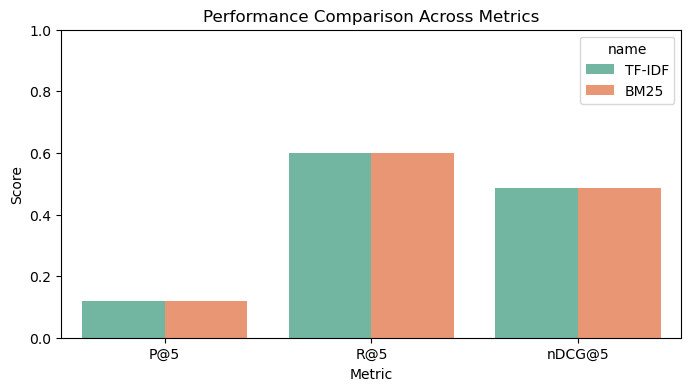

In [22]:
exp_melt = exp.melt(id_vars="name", var_name="Metric", value_name="Score")
plt.figure(figsize=(8,4))
sns.barplot(data=exp_melt, x="Metric", y="Score", hue="name", palette="Set2")
plt.title("Performance Comparison Across Metrics")
plt.ylim(0,1)
plt.show()

## Building the UI

In [23]:
# Initialize a new Flask web application
# Flask is a lightweight Python web framework ideal for demos
app = Flask(__name__)
username = os.environ.get("JUPYTERHUB_USER")
# app.config['APPLICATION_ROOT'] = f'/user/{username}/proxy/5000'

In [24]:
# Run this cell once to load the svg into the static directory for the favicon
svg_content = """
<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="currentColor" class="bi bi-search" viewBox="0 0 16 16">
  <path d="M11.742 10.344a6.5 6.5 0 1 0-1.397 1.398h-.001q.044.06.098.115l3.85 3.85a1 1 0 0 0 1.415-1.414l-3.85-3.85a1 1 0 0 0-.115-.1zM12 6.5a5.5 5.5 0 1 1-11 0 5.5 5.5 0 0 1 11 0"/>
</svg>
"""

with open("static/favicon.svg", "w") as f:
    f.write(svg_content.strip())

In [25]:
# Search endpoint: This route handles search requests like: /search?q=privacy
@app.route("/", methods=["GET"])
def search():
    query = request.args.get("q", "")
    results = []

    if query:
        res = bm25.search(query).head(5)
    
        for rank, row in enumerate(res.itertuples(), start=1):
            doc_rows = df.loc[df["docno"] == row.docno]
            if doc_rows.empty:
                continue  # skips results not in df
    
            doc = doc_rows.iloc[0]
            results.append({
                "rank": len(results) + 1,  # rank in the final list
                "docno": row.docno,
                "snippet": doc["text"][:200],
                "score": round(row.score, 3)
            })

            
    proxy_prefix = f"2025-autumn-info-376-a/user/{username}/proxy/5000"
    return render_template("index.html", results=results, query=query)

# Doc endpoint: This route handles get requests to view doc full text
@app.route("/doc/<docno>")
def display_doc(docno):
    doc = df.loc[df["docno"] == docno].iloc[0]
    proxy_prefix = f"2025-autumn-info-376-a/user/{username}/proxy/5000"
    return render_template("doc_view.html", docno=docno, full_text=doc["text"])


In [ ]:
# Run app (on jupyter server)
# username = os.environ.get("JUPYTERHUB_USER")
print("TechGlossary search ui running at:")
print(f"https://jupyter.rttl.uw.edu/2025-autumn-info-376-a/user/{username}/proxy/5000/")
app.run(host="0.0.0.0", port=5000, debug=False, use_reloader=False)

TechGlossary search ui running at:
https://jupyter.rttl.uw.edu/2025-autumn-info-376-a/user/owenwong/proxy/5000/
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.2.193.228:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Dec/2025 21:23:21] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Dec/2025 21:23:24] "GET /?q=r+studio HTTP/1.1" 200 -


In [ ]:
query = "r studio"  # or request.args.get("q", "") in Flask
query = query.strip()

# Run BM25 search
res = bm25.search(query).head(5)

print("BM25 returned these docnos:")
print(res[["docno", "score"]])